In [1]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from graphviz import Digraph
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import survivors.datasets as ds

import cProfile
import pstats

%load_ext line_profiler
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


In [2]:
X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
X

,htreat,age,menostat,tumsize,tumgrad,posnodal,prm,esm
0,0,70,2,21,2,3,48,66
1,1,56,2,12,2,7,61,77
2,1,58,2,35,2,9,52,271
3,1,59,2,17,2,4,60,29
4,0,73,2,35,2,1,26,65
...,...,...,...,...,...,...,...,...
681,0,49,1,30,3,3,1,84
682,1,53,2,25,3,17,0,0
683,0,51,1,25,3,5,43,0
684,0,52,2,23,2,3,15,34


In [6]:
freq

False    387
True     299
dtype: int64

In [4]:
freq = pd.DataFrame(y[cnt.CENS_NAME]).value_counts()
correct_proba = freq[0] / freq[1]

np.where(y[cnt.CENS_NAME], correct_proba, 1)

array([1.29431438, 1.29431438, 1.29431438, 1.29431438, 1.29431438,
       1.29431438, 1.        , 1.        , 1.29431438, 1.        ,
       1.29431438, 1.29431438, 1.        , 1.        , 1.        ,
       1.29431438, 1.29431438, 1.        , 1.        , 1.29431438,
       1.29431438, 1.        , 1.        , 1.        , 1.29431438,
       1.29431438, 1.29431438, 1.29431438, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.29431438,
       1.        , 1.29431438, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.29431438, 1.        , 1.        ,
       1.        , 1.        , 1.29431438, 1.        , 1.29431438,
       1.29431438, 1.        , 1.29431438, 1.29431438, 1.29431438,
       1.29431438, 1.        , 1.        , 1.        , 1.        ,
       1.29431438, 1.        , 1.29431438, 1.        , 1.        ,
       1.29431438, 1.29431438, 1.29431438, 1.29431438, 1.29431438,
       1.29431438, 1.        , 1.29431438, 1.29431438, 1.29431

In [55]:
# X = X[["max_ESR", "gender", "age"]].dropna()
# X["ref_ESR"] = X["max_ESR"] < 20
# X = X[(X["gender"] == 1) & (X["age"] > 50)].reset_index()
# y = y[X.index]

# feat = "ref_ESR"  # Wuhan

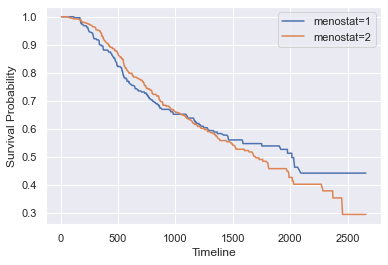

In [56]:
feat = "menostat"  # GBSG (menostat)
# feat = "sex"  # PBC

bins = np.unique(y["time"])

fig = plt.figure()
for v in np.unique(X[feat]):
    index = X.query(f"{feat} == {v}").index
    
    kmf = KaplanMeierFitter()
    kmf.fit(y[index]['time'], event_observed=y[index]['cens'])
    sf_train = kmf.survival_function_at_times(bins).to_numpy()
    plt.plot(bins, sf_train, label=f"{feat}={v}")
plt.ylabel("Survival Probability")
plt.xlabel("Timeline")
plt.legend()

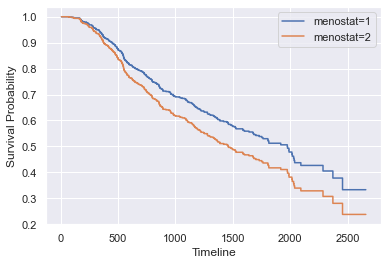

In [57]:
from lifelines import CoxPHFitter
df = X.copy()  # [[feat]]
df["time"] = y["time"]
df["cens"] = y["cens"]

cph = CoxPHFitter().fit(df, 'time', 'cens')  # strata=[feat]
cph.plot_partial_effects_on_outcome(feat, plot_baseline=False, 
                                    values=np.unique(X[feat]))
plt.ylabel("Survival Probability")
plt.xlabel("Timeline")
plt.legend()

In [58]:
plt.figure(figsize=(14, 7))
cph.check_assumptions(df, p_value_threshold=0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\fitters\mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  for variable in self.params_.index & (columns or self.params_.index):
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 686 total observations, 387 right-censored observations>
         test_name = proportional_hazard_test

---
               test_statistic    p  -log2(p)
age      km              2.78 0.10      3.39
         rank            2.65 0.10      3.27
esm      km              0.91 0.34      1.56
         rank            1.32 0.25      2.00
htreat   km              0.17 0.68      0.55
         rank            0.17 0.68      0.55
menostat km              0.01 0.92      0.13
         rank            0.03 0.87      0.20
posnodal km              0.72 0.40      1.34
         rank            0.70 0.40      1.31
prm      km              1.39 0.24      2.07
         rank            1.25 0.26      1.92
tumgrad  km              4.43 0.04      4.82
         rank            5.57 0.02      5.78
tumsize  km              0.24 0.62      0.68
         rank            0.24 0.62      0.68



1. Variable 'tumgrad' failed the non-proportional test: p-value is 0.0182.

   Advice: with so few unique values (only 3), you can include `strata=['tumgrad', ...]` in the call
in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[]

<Figure size 1008x504 with 0 Axes>

In [52]:
from typing import List, Optional, Dict, Any, Iterable
from textwrap import dedent, fill
from autograd import numpy as anp
import numpy as np
from pandas import DataFrame, Series
from lifelines.statistics import proportional_hazard_test, TimeTransformers
from lifelines.utils import format_p_value
from lifelines.utils.lowess import lowess


def plot_assumptions(cph,
        training_df: DataFrame,
        p_value_threshold: float = 0.01,
        plot_n_bootstraps: int = 15,
        columns: Optional[List[str]] = None):    
    residuals = cph.compute_residuals(training_df, kind="scaled_schoenfeld")
    test_results = proportional_hazard_test(cph, training_df, time_transform=["rank", "km"], precomputed_residuals=residuals)

    residuals_and_duration = residuals.join(training_df[cph.duration_col])
    Xs = cph.regressors.transform_df(training_df)

    counter = 0
    n = residuals_and_duration.shape[0]
    axes = []

    for variable in cph.params_.index.intersection(columns or cph.params_.index):
        minumum_observed_p_value = test_results.summary.loc[variable, "p"].min()
        if np.round(minumum_observed_p_value, 2) > p_value_threshold:
            continue
        counter += 1
        # show plots
        axes.append([])
        fig = plt.figure(figsize=(14, 7))

        # plot variable against all time transformations.
        for i, (transform_name, transformer) in enumerate(TimeTransformers().iter(["rank", "km"]), start=1):
            p_value = test_results.summary.loc[(variable, transform_name), "p"]

            ax = fig.add_subplot(1, 2, i)

            y = residuals_and_duration[variable]
            tt = transformer(cph.durations, cph.event_observed, cph.weights)[cph.event_observed.values]

            ax.scatter(tt, y, alpha=0.75)

            y_lowess = lowess(tt.values, y.values)
            ax.plot(tt, y_lowess, color="k", alpha=1.0, linewidth=2)

            # bootstrap some possible other lowess lines. This is an approximation of the 100% confidence intervals
            for _ in range(plot_n_bootstraps):
                ix = sorted(np.random.choice(n, n))
                tt_ = tt.values[ix]
                y_lowess = lowess(tt_, y.values[ix])
                ax.plot(tt_, y_lowess, color="k", alpha=0.30)

            best_xlim = ax.get_xlim()
            ax.hlines(0, 0, tt.max(), linestyles="dashed", linewidths=1)
            ax.set_xlim(best_xlim)

            ax.set_xlabel("%s-transformed time\n(p=%.4f)" % (transform_name, p_value), fontsize=13)
            axes[-1].append(ax)

        fig.suptitle("Scaled Schoenfeld residuals of '%s'" % variable, fontsize=14)
        plt.tight_layout()
#         plt.subplots_adjust(top=0.90)

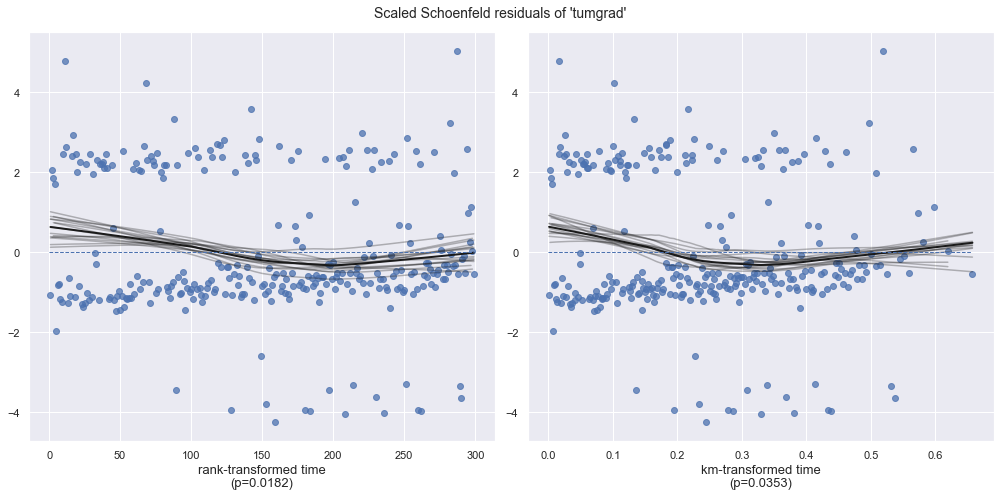

In [62]:
plot_assumptions(cph, df, p_value_threshold=0.05)

### Лучшее разбиение

In [224]:
# X, y, features, categ, sch_nan = ds.load_pbc_dataset()
# X, y, features, categ, sch_nan = ds.load_onk_dataset()
X, y, features, categ, sch_nan = ds.load_covid_dataset()
X

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\covid.py:205: DtypeWarning: Columns (12,33,36,37,46,47,48,49,103,111,112,147,148,247,248,267,268,275,276,283,284,295,296,307,308) have mixed types. Specify dtype option on import or set low_memory=False.
  cyto = pd.read_csv(join(dir_env, "cyto_with_schemes.csv"))


Categ-contin var: has_odyshka_ili_zatrudnennoe_dyhanie
Categ-contin var: has_oschussh_zalozhen_v_grudnoi_kletke
Categ-contin var: has_slabost_ili_lomota
Categ-contin var: Пол
Categ-contin var: PCR_N
Categ-contin var: has_kashel
Categ-contin var: kashel_type
Categorical var: resultat_KT 6


,days_f,days_s,spo2,chdd,has_odyshka_ili_zatrudnennoe_dyhanie,temperatura_tela_value,has_oschussh_zalozhen_v_grudnoi_kletke,has_slabost_ili_lomota,Пол,возраст,...,mos_light_2,mos_middle_1,mos_middle_2,mos_middle_3,mos_middle_4,mos_hard_1,mos_hard_2,mos_hard_3,mos_cyto_1,mos_cyto_2
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,NaN,18.0,NaN,38.1,NaN,NaN,0.0,68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,91,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162913,NaN,NaN,NaN,18.0,NaN,37.6,NaN,NaN,1.0,73,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,88,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162916,1.0,1.0,NaN,18.0,NaN,37.8,NaN,NaN,0.0,72,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [225]:
df = X[features[:20]].copy()
df[cnt.TIME_NAME] = y[cnt.TIME_NAME]
df[cnt.CENS_NAME] = y[cnt.CENS_NAME]

In [226]:
def plot_km_with_ibs(data, label):
    bins = cnt.get_bins(data[cnt.TIME_NAME].values, 
                        cens=data[cnt.CENS_NAME].values)
    kmf = KaplanMeierFitter()
    kmf.fit(data[cnt.TIME_NAME], 
            event_observed=data[cnt.CENS_NAME])
    sf_train = kmf.survival_function_at_times(bins).to_numpy()
    pred_sf = np.repeat(sf_train[np.newaxis, :], data.shape[0], axis=0)
    true_sf = cnt.get_y(data[cnt.CENS_NAME], data[cnt.TIME_NAME])
    ibs_val = round(metr.ibs(true_sf, true_sf, pred_sf, bins), 5)
    plt.plot(bins, sf_train, label=f"{label}: SIZE={data.shape[0]}, IBS={ibs_val}")

====== 0.0 IGG_N


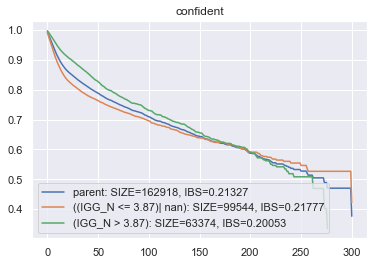

====== 0.0 days_f


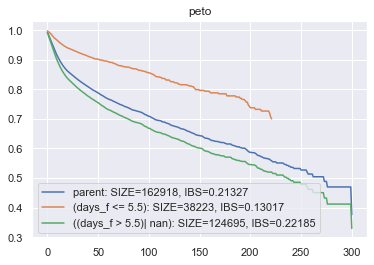

====== 0.0 spo2


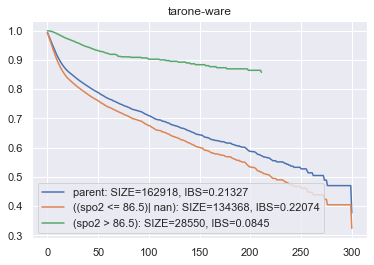

====== 0.0 temperatura_tela_value


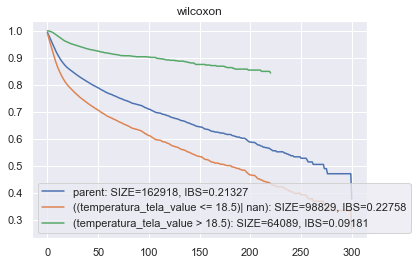

====== 0.0 IGG_N


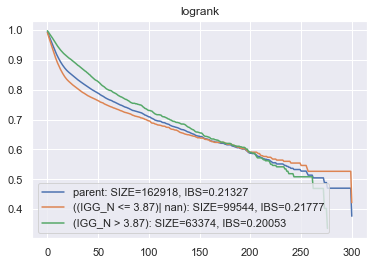

In [227]:
from survivors.tree import Node
# from survivors.tree.find_split_hist import hist_best_attr_split

for crit in ["confident", "peto", "tarone-ware", "wilcoxon", "logrank"]:
    n = Node(df, features=df.columns[:-2], criterion=crit, min_samples_leaf=1, signif=0.01, verbose=1)
    subnodes = n.split()
    
    plot_km_with_ibs(n.df, "parent")
    plot_km_with_ibs(subnodes[0].df, f"{subnodes[0].full_rule[0].to_str()}")
    plot_km_with_ibs(subnodes[1].df, f"{subnodes[1].full_rule[0].to_str()}")
    plt.legend()
    plt.title(crit)
    plt.show()

====== 0.0 возраст


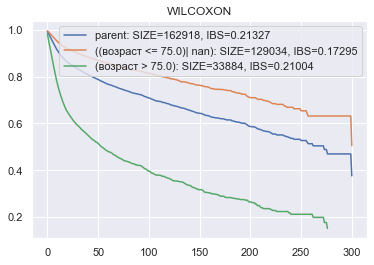

====== 0.0 IGM_DEF


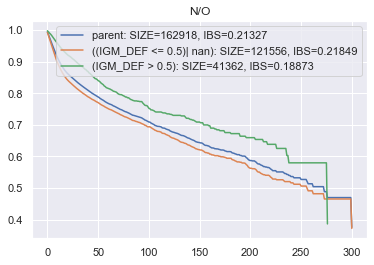

====== 0.0 возраст


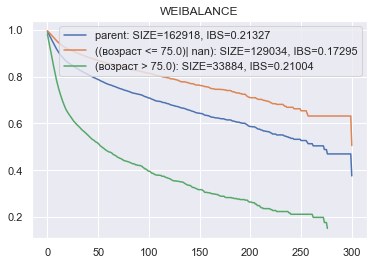

In [228]:
from survivors.tree import Node
# from survivors.tree.find_split_hist import hist_best_attr_split

name_wei = "wei"
wei_d = {
    "WILCOXON": np.repeat(1, df.shape[0], axis=0),
    "N/O": np.repeat(df.shape[0] / np.sum(df[cnt.CENS_NAME]), df.shape[0], axis=0),
    "WEIBALANCE": np.where(df[cnt.CENS_NAME], 100000000, 1)
#     "WEIBALANCE": np.where(df[cnt.CENS_NAME], (df.shape[0] - np.sum(df[cnt.CENS_NAME])) / np.sum(df[cnt.CENS_NAME]), 1)
}

for wei in wei_d.keys():
    df[name_wei] = wei_d[wei]
    
    n = Node(df, features=df.columns[:-3], criterion="weights", 
             weights_feature = name_wei,
             min_samples_leaf=10, signif=0.15, verbose = 1)
    subnodes = n.split()
    
    plot_km_with_ibs(n.df, "parent")
    plot_km_with_ibs(subnodes[0].df, f"{subnodes[0].full_rule[0].to_str()}")
    plot_km_with_ibs(subnodes[1].df, f"{subnodes[1].full_rule[0].to_str()}")
    plt.legend()
    plt.title(wei)
    plt.show()

====== 0.0 IGG_DEF


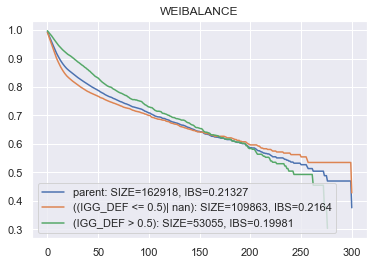

In [229]:

n = Node(df, features=df.columns[:-3], criterion="wilcoxon",
         min_samples_leaf=10, signif=0.15, verbose = 1)
subnodes = n.split()

plot_km_with_ibs(n.df, "parent")
plot_km_with_ibs(subnodes[0].df, f"{subnodes[0].full_rule[0].to_str()}")
plot_km_with_ibs(subnodes[1].df, f"{subnodes[1].full_rule[0].to_str()}")
plt.legend()
plt.title(wei)
plt.show()

====== 2.980929699458641e-16 Tumor_опухоль


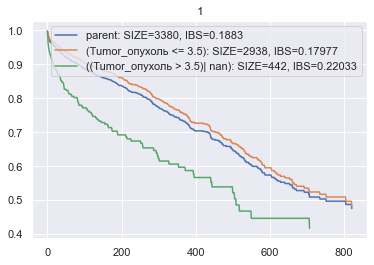

====== 1.2975139173579495e-30 Индекс_массы


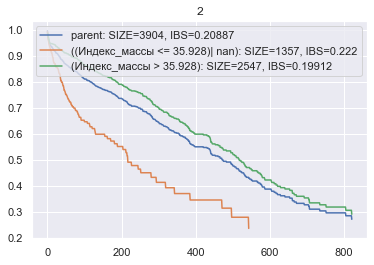

====== 4.53873759996124e-48 Вес


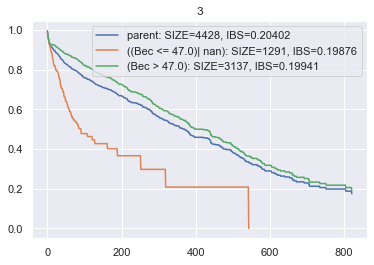

====== 8.32115787537372e-68 Вес


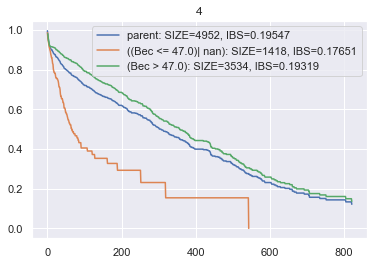

====== 7.167793612352785e-89 Вес


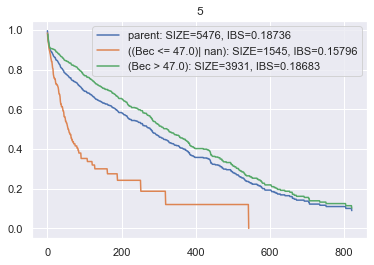

In [44]:
df_ = df.copy()

for k in range(1, 6):
    n = Node(df_, features=df_.columns[:-3], criterion="wilcoxon",
             min_samples_leaf=10, signif=0.15, verbose = 1)
    subnodes = n.split()

    plot_km_with_ibs(n.df, "parent")
    plot_km_with_ibs(subnodes[0].df, f"{subnodes[0].full_rule[0].to_str()}")
    plot_km_with_ibs(subnodes[1].df, f"{subnodes[1].full_rule[0].to_str()}")
    plt.legend()
    plt.title(k)
    plt.show()
    df_ = pd.concat([df_, df[df[cnt.CENS_NAME]]])

In [42]:
df_ = df.copy()

for wei in range(-5, 5):
    df[name_wei] = np.where(df[cnt.CENS_NAME], np.exp(wei), 1)
    
    n = Node(df, features=df.columns[:-3], criterion="weights", 
             weights_feature = name_wei,
             min_samples_leaf=10, signif=0.15, verbose = 1)
    subnodes = n.split()
    
#     plot_km_with_ibs(n.df, "parent")
#     plot_km_with_ibs(subnodes[0].df, f"{subnodes[0].full_rule[0].to_str()}")
#     plot_km_with_ibs(subnodes[1].df, f"{subnodes[1].full_rule[0].to_str()}")
#     plt.legend()
#     plt.title(wei)
#     plt.show()

====== 3.0778470924476782e-16 Tumor_опухоль
====== 3.076263200308025e-16 Tumor_опухоль
====== 3.072467563540098e-16 Tumor_опухоль
====== 3.06229369263848e-16 Tumor_опухоль
====== 3.0367300159877115e-16 Tumor_опухоль
====== 2.980929699458641e-16 Tumor_опухоль
====== 2.888115812965264e-16 Tumor_опухоль
====== 2.7904498961974245e-16 Tumor_опухоль
====== 2.730254881906742e-16 Tumor_опухоль
====== 2.7046051136557327e-16 Tumor_опухоль


## Balanced log-rank

In [483]:
import numpy as np
from numba import njit

from scipy import stats
from survivors.tree.stratified_model import KaplanMeier

""" Auxiliary functions """


@njit('f4(u4[:], u4[:], u4[:], u4[:], u4, f4[:])', cache=True)
def lr_hist_statistic(time_hist_1, time_hist_2, cens_hist_1, cens_hist_2,
                      weightings, obs_weights):
    N_1_j = np.cumsum(time_hist_1[::-1])[::-1]
    N_2_j = np.cumsum(time_hist_2[::-1])[::-1]
    ind = np.where((cens_hist_1 + cens_hist_2 != 0) & (N_1_j * N_2_j != 0))[0]
    if ind.shape[0] == 0:
        return 0.0

    N_1_j = N_1_j[ind]
    N_2_j = N_2_j[ind]
    O_1_j = cens_hist_1[ind]
    O_2_j = cens_hist_2[ind]

    N_j = N_1_j + N_2_j
    O_j = O_1_j + O_2_j
    E_1_j = N_1_j * O_j / N_j
    res = np.zeros((N_j.shape[0], 3), dtype=np.float32)
    res[:, 1] = O_1_j - E_1_j
    res[:, 2] = E_1_j * (N_j - O_j) * N_2_j / (N_j * (N_j - 1))
    
    res[:, 0] = 1.0
    if weightings == 2:
        res[:, 0] = N_j
    elif weightings == 3:
        res[:, 0] = np.sqrt(N_j)
    elif weightings == 4:
        res[:, 0] = np.cumprod((1.0 - O_j / (N_j + 1)))
    elif weightings == 5:
        res[:, 0] = obs_weights[ind]
        # Empirical
    elif weightings == 6:
        res[:, 0] = O_j
    elif weightings == 7:
        res[:, 0] = 1/O_j
    elif weightings == 8:
        res[:, 0] = np.cumsum(O_j[::-1])[::-1]
    elif weightings == 9:
        s_O_j = np.cumsum(O_j[::-1])[::-1]
        res[:, 0] = 1/s_O_j
#     res_ = pd.DataFrame(res)
#     res_["N_j"] = N_j
#     res_["O_j"] = O_j
#     res_["O_1_j"] = O_1_j
#     res_["E_1_j"] = E_1_j
#     print(res_)
    stat_val = np.power((res[:, 0] * res[:, 1]).sum(), 2) / ((res[:, 0] * res[:, 0] * res[:, 2] ).sum())
#     print("!!!stat_val:", np.sqrt(stat_val))
    return stat_val # np.sqrt(stat_val)


def weight_hist_stat(time_hist_1, time_hist_2, cens_hist_1=None, cens_hist_2=None, weights_hist=None, weightings=""):
    try:
        if cens_hist_1 is None:
            cens_hist_1 = time_hist_1
        if cens_hist_2 is None:
            cens_hist_2 = time_hist_2
        if weights_hist is None:
            weights_hist = np.ones_like(time_hist_1)
        d = {"logrank": 1, "wilcoxon": 2, "tarone-ware": 3, "peto": 4, "weights": 5}
        d.update({"O_j": 6, "1/O_j": 7, "cumul_O_j": 8, "1/cumul_O_j": 9})
        weightings = d.get(weightings, 1)
        logrank = lr_hist_statistic(time_hist_1.astype("uint32"),
                                    time_hist_2.astype("uint32"),
                                    cens_hist_1.astype("uint32"),
                                    cens_hist_2.astype("uint32"),
                                    np.uint32(weightings),
                                    weights_hist.astype("float32"))
        return logrank
    except Exception as err:
#         print(err)
#         print(time_hist_1, time_hist_2, cens_hist_1, cens_hist_2, weights_hist)
        return 0.0


def optimal_criter_split_hist(left_time_hist, left_cens_hist,
                              right_time_hist, right_cens_hist,
                              na_time_hist, na_cens_hist, weights_hist, criterion, dis_coef):
    none_to = 0
    max_stat_val = 1.0
    
    if dis_coef > 1:
        left_time_hist = left_time_hist + (dis_coef - 1)*left_cens_hist
        right_time_hist = right_time_hist + (dis_coef - 1)*right_cens_hist
        na_time_hist = na_time_hist + (dis_coef - 1)*na_cens_hist
        
        left_cens_hist = left_cens_hist*dis_coef
        right_cens_hist = right_cens_hist*dis_coef
        na_cens_hist = na_cens_hist*dis_coef
    
    if na_time_hist.shape[0] > 0:
        a = weight_hist_stat(left_time_hist + na_time_hist, right_time_hist,
                             left_cens_hist + na_cens_hist, right_cens_hist,
                             weights_hist, weightings=criterion)
        b = weight_hist_stat(left_time_hist, right_time_hist + na_time_hist,
                             left_cens_hist, right_cens_hist + na_cens_hist,
                             weights_hist, weightings=criterion)
        # Nans move to a leaf with maximal statistical value
        none_to = int(a < b)
        max_stat_val = max(a, b)
        # print(a, b)
    else:
        max_stat_val = weight_hist_stat(left_time_hist, right_time_hist,
                                        left_cens_hist, right_cens_hist,
                                        weights_hist, weightings=criterion)
    return (max_stat_val, none_to)


def split_time_to_bins(time):
    return np.searchsorted(np.unique(time), time)


def get_attrs(max_stat_val, values, none_to, l_sh, r_sh, nan_sh):
    attrs = dict()
    attrs["stat_val"] = max_stat_val
    attrs["values"] = values
    if none_to:
        attrs["pos_nan"] = [0, 1]
        attrs["min_split"] = min(l_sh, r_sh + nan_sh)
    else:
        attrs["pos_nan"] = [1, 0]
        attrs["min_split"] = min(l_sh + nan_sh, r_sh)
    return attrs


def transform_woe_np(x_feat, y):
    N_T = y.shape[0]
    N_D = y.sum()
    N_D_ = N_T - N_D
    x_uniq = np.unique(x_feat)
    x_dig = np.digitize(x_feat, x_uniq) - 1

    df_woe_iv = np.vstack([np.bincount(x_dig[y == 0], minlength=x_uniq.shape[0]),
                           np.bincount(x_dig[y == 1], minlength=x_uniq.shape[0])])
    all_0 = df_woe_iv[0].sum()
    all_1 = df_woe_iv[1].sum()

    p_bd = (df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
    p_bd_ = (df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)
    p_b_d = (all_1 - df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
    p_b_d_ = (all_0 - df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)

    woe_pl = np.log(p_bd / p_bd_)
    woe_mn = np.log(p_b_d / p_b_d_)
    descr_np = np.vstack([x_uniq, woe_pl - woe_mn])
    features_woe = dict(zip(descr_np[0], descr_np[1]))
    woe_x_feat = np.vectorize(features_woe.get)(x_feat)
    # calculate information value
    # iv = ((p_bd - p_bd_)*woe_pl).sum()
    return (woe_x_feat, descr_np)


def get_sa_hists(time, cens, minlength=1):
    if time.shape[0] > 0:
        time_hist = np.bincount(time, minlength=minlength)
        cens_hist = np.bincount(time, weights=cens, minlength=minlength).astype("int32")
    else:
        time_hist, cens_hist = np.array([]), np.array([])
    return time_hist, cens_hist


def select_best_split_info(attr_dicts, type_attr, bonf=True, descr_woe=None):
    best_attr = max(attr_dicts, key=lambda x: x["stat_val"])
    best_attr["p_value"] = stats.chi2.sf(best_attr["stat_val"], df=1)
    best_attr["sign_split"] = len(attr_dicts)
    if best_attr["sign_split"] > 0:
        if type_attr == "cont":
            best_attr["values"] = [f" <= {best_attr['values']}", f" > {best_attr['values']}"]
        # elif type_attr == "categ":
        #     best_attr["values"] = [f" in {e}" for e in best_attr["values"]]
        elif type_attr == "woe" or type_attr == "categ":
            ind = descr_woe[1] <= best_attr["values"]
            l, r = list(descr_woe[0, ind]), list(descr_woe[0, ~ind])
            best_attr["values"] = [f" in {e}" for e in [l, r]]
        if bonf:
            best_attr["p_value"] *= best_attr["sign_split"]
    return best_attr


def hist_best_attr_split(arr, criterion="logrank", type_attr="cont", weights=None, thres_cont_bin_max=100,
                         signif=1.0, signif_stat=0.0, min_samples_leaf=10, bonf=True, verbose=0, **kwargs):
    best_attr = {"stat_val": signif_stat, "p_value": signif,
                 "sign_split": 0, "values": [], "pos_nan": [1, 0]}
    if arr.shape[1] < 2 * min_samples_leaf:
        return best_attr
    vals = arr[0].astype("float")
    cens = arr[1].astype("uint")
    dur = arr[2].astype("float")
    
    dis_coef = max(1, (cens.shape[0] - np.sum(cens)) // np.sum(cens))
    # print("dis_coef:", dis_coef)

    dur = split_time_to_bins(dur)
    max_bin = dur.max()

    ind = np.isnan(vals)

    # split nan and not-nan
    dur_notna = dur[~ind]
    cens_notna = cens[~ind]
    vals_notna = vals[~ind]

    if dur_notna.shape[0] < min_samples_leaf:
        return best_attr

    descr_woe = None
    if type_attr == "woe" or type_attr == "categ":
        vals_notna, descr_woe = transform_woe_np(vals_notna, cens_notna)

    # find splitting values
    uniq_set = np.unique(vals_notna)
    if uniq_set.shape[0] > thres_cont_bin_max:
        uniq_set = np.quantile(vals_notna, [i / float(thres_cont_bin_max) for i in range(1, thres_cont_bin_max)])
    else:
        uniq_set = (uniq_set[:-1] + uniq_set[1:]) * 0.5
    uniq_set = np.unique(np.round(uniq_set, 3))

    index_vals_bin = np.digitize(vals_notna, uniq_set, right=True)

    # find global hist by times
    na_time_hist, na_cens_hist = get_sa_hists(dur[ind], cens[ind], minlength=max_bin + 1)
    r_time_hist, r_cens_hist = get_sa_hists(dur_notna, cens_notna, minlength=max_bin + 1)
    l_time_hist = np.zeros_like(r_time_hist, dtype=np.int32)
    l_cens_hist = l_time_hist.copy()

    num_nan = ind.sum()
    num_r = dur_notna.shape[0]
    num_l = 0

    if criterion == "confident" or criterion == "confident_weights":
        kmf = KaplanMeier()
        if criterion == "confident_weights":
            kmf.fit(dur, cens, weights=weights)
        else:
            kmf.fit(dur, cens)
        ci = kmf.get_confidence_interval_()
        weights_hist = 1 / (ci[1:, 1] - ci[1:, 0] + 1e-5)  # (ci[1:, 1] + ci[1:, 0] + 1e-5)
        criterion = "weights"
    elif weights is None:
        weights_hist = None
    else:
        weights_hist = np.bincount(dur, weights=weights,  # /sum(weights),
                                   minlength=max_bin + 1)
        weights_hist = np.cumsum(weights_hist[::-1])[::-1]  # np.sqrt()
        # weights_hist = weights_hist / weights_hist.sum()

    # for each split values get branches
    attr_dicts = []
    for u in np.unique(index_vals_bin)[:-1]:
        curr_mask = index_vals_bin == u
        curr_n = curr_mask.sum()
        curr_time_hist, curr_cens_hist = get_sa_hists(dur_notna[curr_mask],
                                                      cens_notna[curr_mask],
                                                      minlength=max_bin + 1)
        l_time_hist += curr_time_hist
        l_cens_hist += curr_cens_hist
        r_time_hist -= curr_time_hist
        r_cens_hist -= curr_cens_hist
        num_l += curr_n
        num_r -= curr_n

        if min(num_l, num_r) <= min_samples_leaf:
            continue
        max_stat_val, none_to = optimal_criter_split_hist(
            l_time_hist, l_cens_hist, r_time_hist, r_cens_hist,
            na_time_hist, na_cens_hist, weights_hist, criterion, dis_coef)

        if max_stat_val >= signif_stat:
            attr_loc = get_attrs(max_stat_val, uniq_set[u], none_to, num_l, num_r, num_nan)
            attr_dicts.append(attr_loc)
    if len(attr_dicts) == 0:
        return best_attr
    best_attr = select_best_split_info(attr_dicts, type_attr, bonf, descr_woe=descr_woe)
    if verbose > 0:
        print(best_attr["stat_val"], best_attr["p_value"], len(uniq_set))
    return best_attr

In [484]:
from survivors.tree import Node

class BalanceNode(Node):
    def find_best_split(self):
        numb_feats = self.info["max_features"]
        numb_feats = np.clip(numb_feats, 1, len(self.features))
        n_jobs = min(numb_feats, self.info["n_jobs"])

        selected_feats = list(np.random.choice(self.features, size=numb_feats, replace=False))
        # args = self.get_comb(selected_feats)
        args = self.get_comb_fast(selected_feats)

        # ml = np.vectorize(lambda x: hist_best_attr_split(**x))(args)

        with Parallel(n_jobs=1, verbose=0, batch_size=10) as parallel:  # prefer="threads"
            ml = parallel(delayed(hist_best_attr_split)(**a) for a in args)  # hist_best_attr_split
        attrs = {f: ml[ind] for ind, f in enumerate(selected_feats)}

        attr = min(attrs, key=lambda x: attrs[x]["p_value"])
        if attrs[attr]["sign_split"] > 0 and self.info["bonf"]:
            attrs[attr]["p_value"] = attrs[attr]["p_value"] / attrs[attr]["sign_split"]
        return (attr, attrs[attr])

In [498]:
# X, y, features, categ, sch_nan = ds.load_pbc_dataset()
# X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
# X, y, features, categ, sch_nan = ds.load_wuhan_dataset()
# X, y, features, categ, sch_nan = ds.load_onk_dataset()
X, y, features, categ, sch_nan = ds.load_covid_dataset()

df = X[features[:20]].copy()
df[cnt.TIME_NAME] = y[cnt.TIME_NAME]
df[cnt.CENS_NAME] = y[cnt.CENS_NAME]

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\covid.py:205: DtypeWarning: Columns (12,33,36,37,46,47,48,49,103,111,112,147,148,247,248,267,268,275,276,283,284,295,296,307,308) have mixed types. Specify dtype option on import or set low_memory=False.
  cyto = pd.read_csv(join(dir_env, "cyto_with_schemes.csv"))


Categ-contin var: has_odyshka_ili_zatrudnennoe_dyhanie
Categ-contin var: has_oschussh_zalozhen_v_grudnoi_kletke
Categ-contin var: has_slabost_ili_lomota
Categ-contin var: Пол
Categ-contin var: PCR_N
Categ-contin var: has_kashel
Categ-contin var: kashel_type
Categorical var: resultat_KT 6


In [499]:
X

,days_f,days_s,spo2,chdd,has_odyshka_ili_zatrudnennoe_dyhanie,temperatura_tela_value,has_oschussh_zalozhen_v_grudnoi_kletke,has_slabost_ili_lomota,Пол,возраст,...,mos_light_2,mos_middle_1,mos_middle_2,mos_middle_3,mos_middle_4,mos_hard_1,mos_hard_2,mos_hard_3,mos_cyto_1,mos_cyto_2
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,NaN,18.0,NaN,38.1,NaN,NaN,0.0,68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,91,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162913,NaN,NaN,NaN,18.0,NaN,37.6,NaN,NaN,1.0,73,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,88,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162916,1.0,1.0,NaN,18.0,NaN,37.8,NaN,NaN,0.0,72,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


====== 0.0 chdd


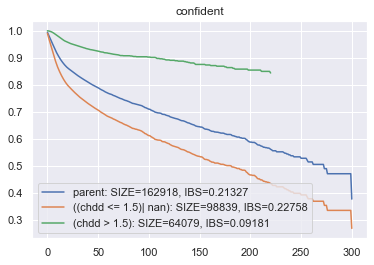

====== 0.0 IGM_DEF


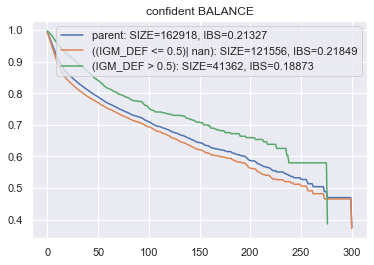

====== 0.0 IGG_N


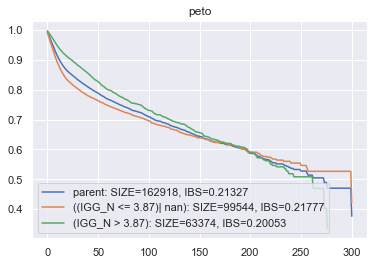

====== 0.0 возраст


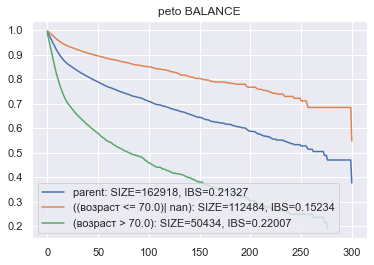

====== 0.0 IGG_DEF


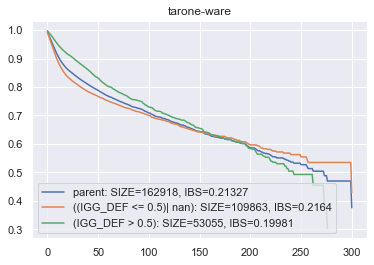

====== 0.0 spo2


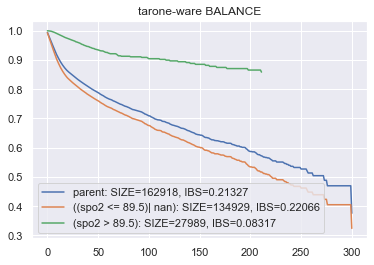

====== 0.0 IGG_N


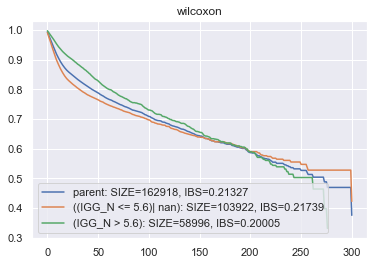

====== 0.0 IGM_N


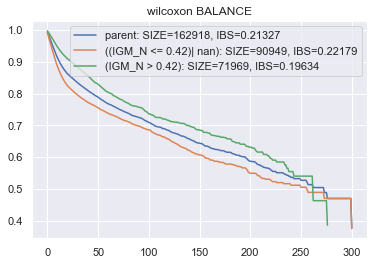

====== 0.0 ОпределениебелковостройфазыСреактивныйбелок


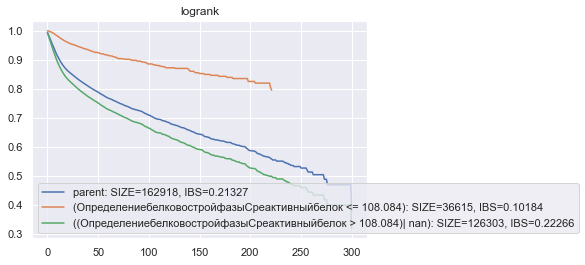

====== 0.0 IGG_DEF


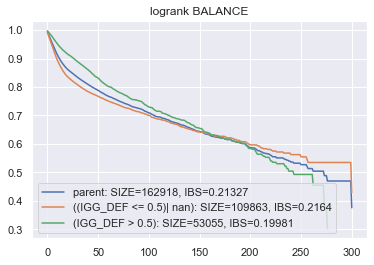

In [500]:
for crit in ["confident", "peto", "tarone-ware", "wilcoxon", "logrank"]:
#              "O_j", "1/O_j", "cumul_O_j", "1/cumul_O_j"]:
    n = Node(df, features=df.columns[:-2], criterion=crit, min_samples_leaf=10, signif=0.1, verbose=1)
    subnodes = n.split()
    
    plot_km_with_ibs(n.df, "parent")
    plot_km_with_ibs(subnodes[0].df, f"{subnodes[0].full_rule[0].to_str()}")
    plot_km_with_ibs(subnodes[1].df, f"{subnodes[1].full_rule[0].to_str()}")
    plt.legend()
    plt.title(crit)
    plt.show()
    
#     df_ = pd.concat([df] + [df[df[cnt.CENS_NAME]]]*4)
#     n = Node(df_, features=df.columns[:-2], criterion=crit, min_samples_leaf=10, signif=0.01, verbose=1)
#     subnodes = n.split()
    
#     plot_km_with_ibs(n.df, "parent")
#     plot_km_with_ibs(subnodes[0].df, f"{subnodes[0].full_rule[0].to_str()}")
#     plot_km_with_ibs(subnodes[1].df, f"{subnodes[1].full_rule[0].to_str()}")
#     plt.legend()
#     plt.title(f"{crit} SAMPLE")
#     plt.show()

    n = BalanceNode(df, features=df.columns[:-2], criterion=crit, min_samples_leaf=10, signif=0.1, verbose=1)
    subnodes = n.split()

    plot_km_with_ibs(n.df, "parent")
    plot_km_with_ibs(subnodes[0].df, f"{subnodes[0].full_rule[0].to_str()}")
    plot_km_with_ibs(subnodes[1].df, f"{subnodes[1].full_rule[0].to_str()}")
    plt.legend()
    plt.title(f"{crit} BALANCE")
    plt.show()

In [494]:
np.concatenate([np.array([1]), np.array([1])])

array([1, 1])

In [433]:
def plot_hist(dur1, dur2, cens1, cens2):
    fig, axes = plt.subplots(figsize=(14, 5), ncols=2)
    axes[0].hist(dur1, label="time")
    axes[0].hist(dur1, weights=cens1, label="cens")
    axes[1].hist(dur2, label="time")
    axes[1].hist(dur2, weights=cens2, label="cens")
    plt.legend()
    plt.show()
    
def plot_km(dur1, dur2, cens1, cens2):
    kmf = KaplanMeierFitter(label="1")
    kmf.fit(dur1, cens1)
    kmf.plot()
    kmf = KaplanMeierFitter(label="2")
    kmf.fit(dur2, cens2)
    kmf.plot()

def show_stat_difference(dur1, dur2, cens1, cens2):
    cens = np.concatenate([cens1, cens2])
    time = np.concatenate([dur1, dur2])
    
    bins = np.unique(time)
    dur1 = np.searchsorted(bins, dur1)
    dur2 = np.searchsorted(bins, dur2)
    
    dis_coef = max(1, (cens.shape[0] - np.sum(cens)) // np.sum(cens))
    print("dis_coef:", dis_coef)
    max_bin = time.shape[0]
    l_time_hist, l_cens_hist = get_sa_hists(dur1, cens1, minlength=max_bin + 1)
    r_time_hist, r_cens_hist = get_sa_hists(dur2, cens2, minlength=max_bin + 1)
    
    plot_hist(dur1, dur2, cens1, cens2)
    plot_km(dur1, dur2, cens1, cens2)
    
    max_stat_val, none_to = optimal_criter_split_hist(
                l_time_hist, l_cens_hist, r_time_hist, r_cens_hist,
                np.array([]), np.array([]), None, "logrank", 1)
    print("BASE:", max_stat_val, stats.chi2.sf(max_stat_val, df=1))
    
    max_stat_val_dis, none_to = optimal_criter_split_hist(
                l_time_hist, l_cens_hist, r_time_hist, r_cens_hist,
                np.array([]), np.array([]), None, "logrank", dis_coef)
    print("BALANCE:", max_stat_val_dis, stats.chi2.sf(max_stat_val_dis, df=1))

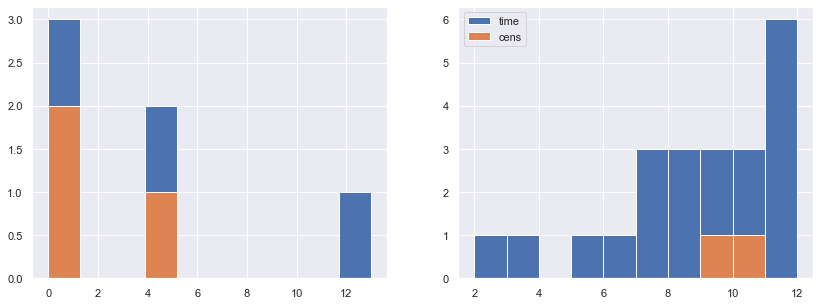

BASE: 8.85759449005127 0.0029187195872139695
BALANCE: 26.742774963378906 2.3241911893169759e-07


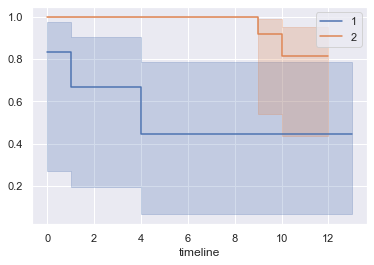

In [370]:
# dur1 = np.array([1, 10, 100, 100, 1000])
# cens1 = np.array([0, 0, 1, 1, 0])

# dur2 = np.array([20, 40, 120, 200, 300])
# cens2 = np.array([0, 0, 0, 0, 0])


dur1 = np.array([1, 10, 10, 100, 100, 1000])
cens1 = np.array([1, 1, 0, 1, 0, 0])

dur2 = np.array([20, 40, 120, 200, 300, 220, 240, 520, 600, 700, 
                 300, 220, 240, 520, 600, 700, 
                 300, 220, 240, 520, 600, 700])
cens2 = np.array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 
                  0, 0, 0, 0, 0, 0, 
                  0, 0, 0, 0, 0, 0])

show_stat_difference(dur1, dur2, cens1, cens2)

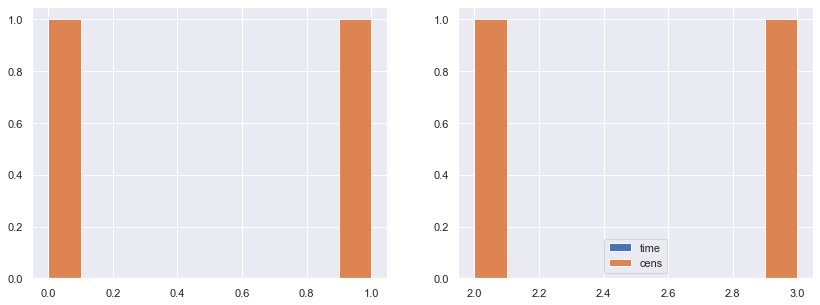

BASE: 2.8823533058166504 0.08955505413653674
BALANCE: 2.8823533058166504 0.08955505413653674


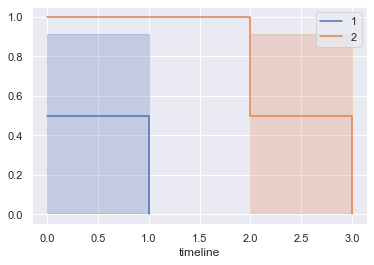

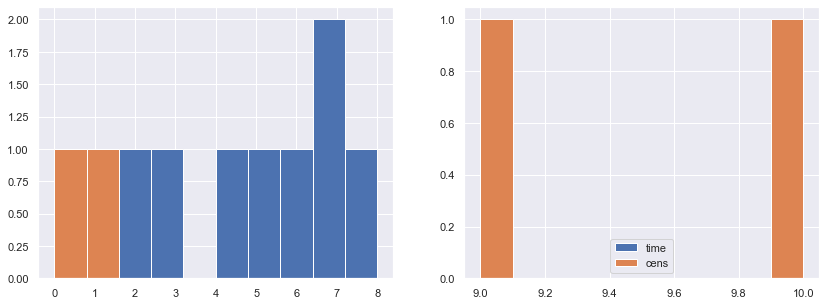

BASE: 0.42218682169914246 0.5158478748539876
BALANCE: 1.5795440673828125 0.2088263791271705


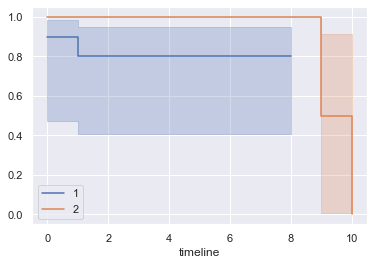

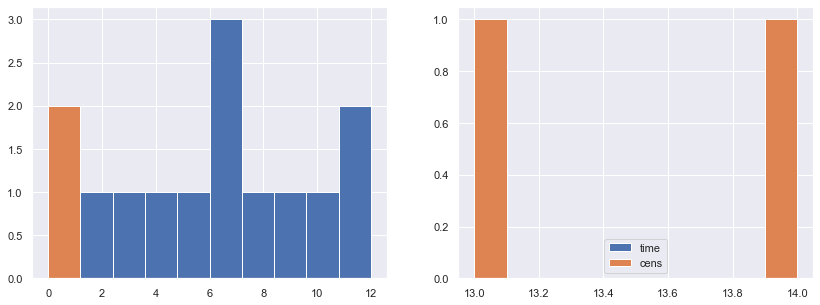

BASE: 0.2966965138912201 0.5859608600517202
BALANCE: 2.4261605739593506 0.11932483877105247


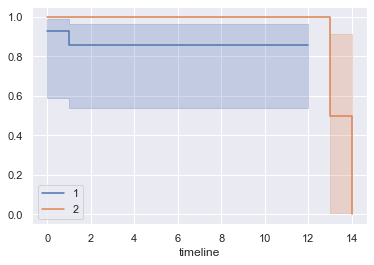

In [399]:
# Add cens on the right (sample1)
dur1_0 = np.array([1, 10])
cens1_0 = np.array([1, 1])

dur1_1 = np.array([1, 10, 30, 50, 60, 70, 80, 100, 100, 200])
cens1_1 = np.array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

dur1_2 = np.array([1, 10, 30, 50, 60, 70, 80, 100, 100, 200, 300, 400, 500, 600])
cens1_2 = np.array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

dur2 = np.array([1000, 1200])
cens2 = np.array([1, 1])

show_stat_difference(dur1_0, dur2, cens1_0, cens2)
show_stat_difference(dur1_1, dur2, cens1_1, cens2)
show_stat_difference(dur1_2, dur2, cens1_2, cens2)

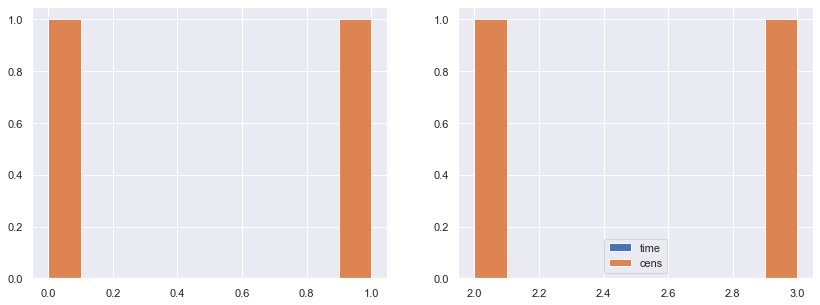

BASE: 2.8823533058166504 0.08955505413653674
BALANCE: 2.8823533058166504 0.08955505413653674


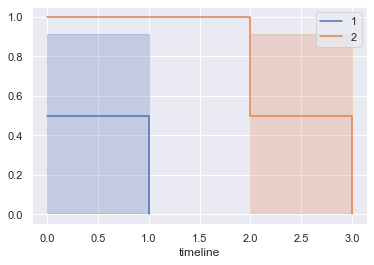

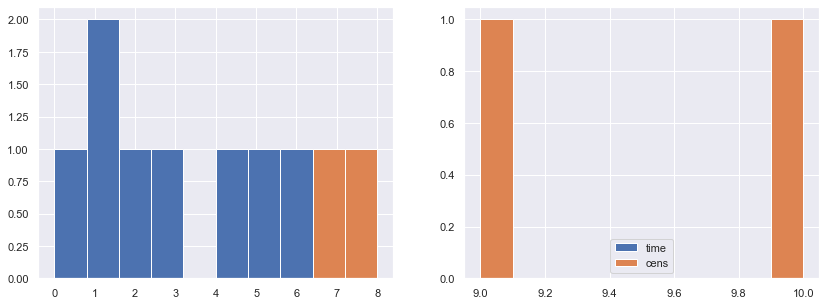

BASE: 2.8823533058166504 0.08955505413653674
BALANCE: 6.9433207511901855 0.008413277955631836


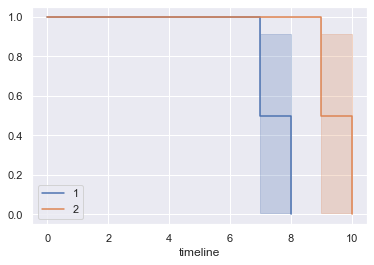

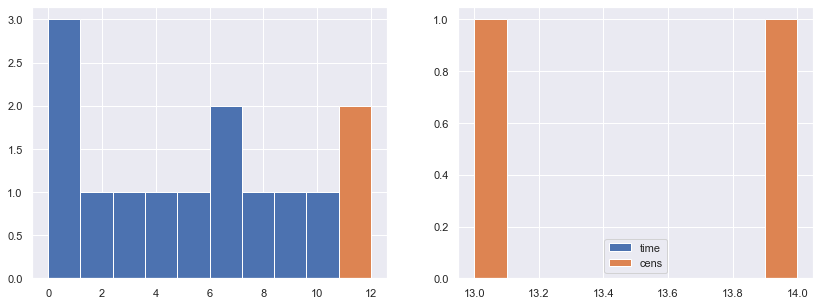

BASE: 2.8823533058166504 0.08955505413653674
BALANCE: 11.0 0.0009111188771537126


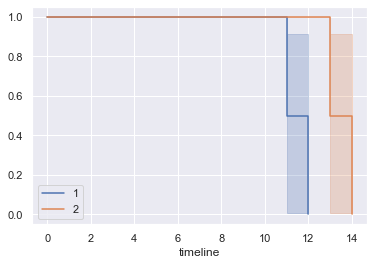

In [395]:
# Add cens on the left(sample1)
dur1_0 = np.array([500, 600])
cens1_0 = np.array([1, 1])

dur1_1 = np.array([1, 10, 10, 50, 60, 70, 80, 100, 500, 600])
cens1_1 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

dur1_2 = np.array([1, 10, 10, 50, 60, 70, 80, 100, 200, 250, 300, 350, 500, 600])
cens1_2 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

dur2 = np.array([700, 1200])
cens2 = np.array([1, 1])

show_stat_difference(dur1_0, dur2, cens1_0, cens2)
show_stat_difference(dur1_1, dur2, cens1_1, cens2)
show_stat_difference(dur1_2, dur2, cens1_2, cens2)

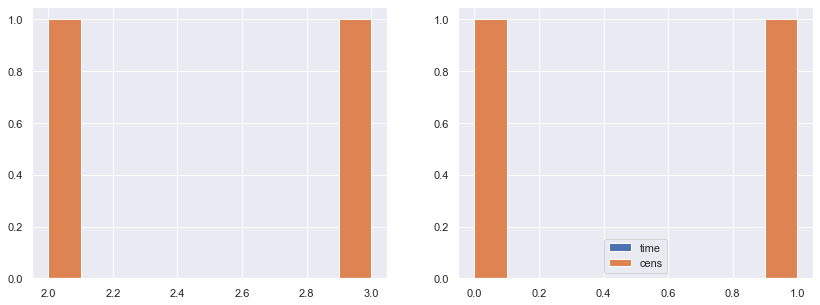

BASE: 2.8823533058166504 0.08955505413653674
BALANCE: 2.8823533058166504 0.08955505413653674


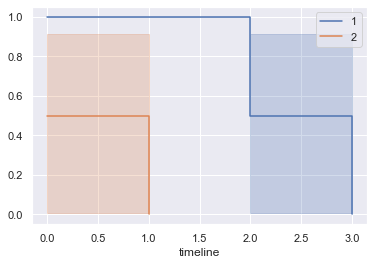

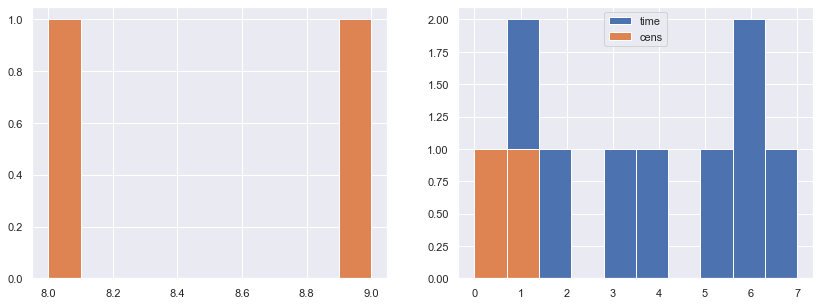

BASE: 0.42218682169914246 0.5158478748539876
BALANCE: 1.5795440673828125 0.2088263791271705


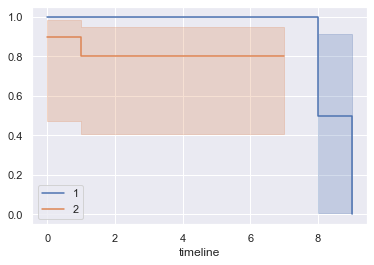

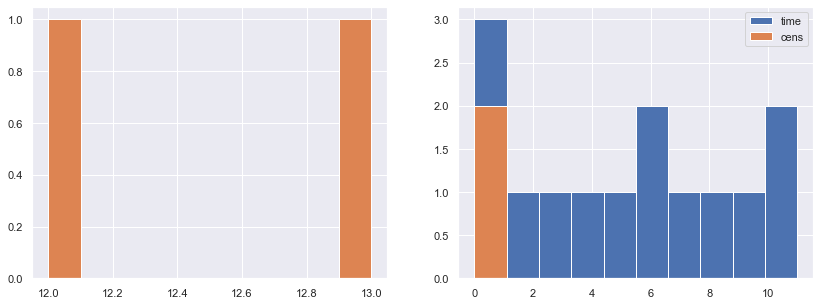

BASE: 0.2966965138912201 0.5859608600517202
BALANCE: 2.4261605739593506 0.11932483877105247


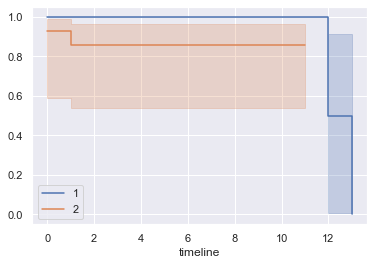

In [428]:
# Add cens on the right (sample2)
dur1 = np.array([1000, 1200])
cens1 = np.array([1, 1])

dur2_0 = np.array([1, 10])
cens2_0 = np.array([1, 1])

dur2_1 = np.array([1, 10, 10, 50, 60, 70, 80, 100, 100, 120])
cens2_1 = np.array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

dur2_2 = np.array([1, 10, 10, 50, 60, 70, 80, 100, 100, 120, 130, 140, 150, 160])
cens2_2 = np.array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

show_stat_difference(dur1, dur2_0, cens1, cens2_0)
show_stat_difference(dur1, dur2_1, cens1, cens2_1)
show_stat_difference(dur1, dur2_2, cens1, cens2_2)

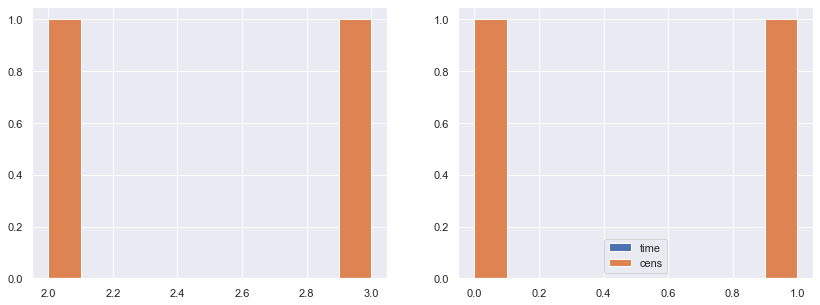

BASE: 2.8823533058166504 0.08955505413653674
BALANCE: 2.8823533058166504 0.08955505413653674


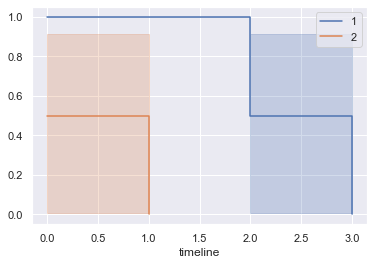

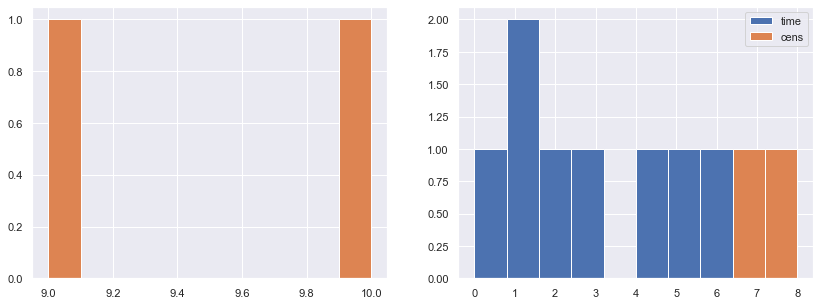

BASE: 2.8823533058166504 0.08955505413653674
BALANCE: 6.9433207511901855 0.008413277955631836


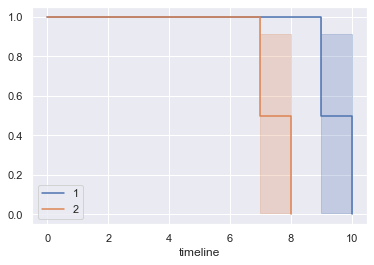

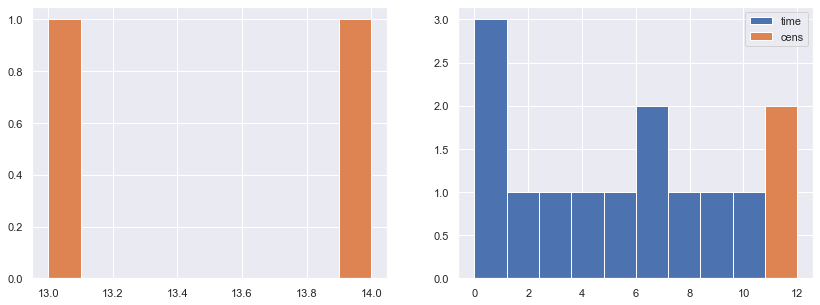

BASE: 2.8823533058166504 0.08955505413653674
BALANCE: 11.0 0.0009111188771537126


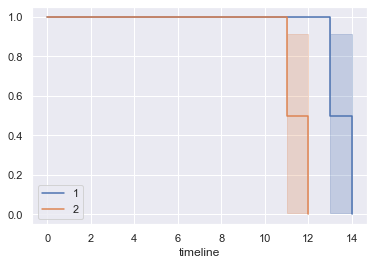

In [427]:
# Add cens on the left(sample2)
dur1 = np.array([700, 1200])
cens1 = np.array([1, 1])

dur2_0 = np.array([500, 600])
cens2_0 = np.array([1, 1])

dur2_1 = np.array([1, 10, 10, 50, 60, 70, 80, 100, 500, 600])
cens2_1 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

dur2_2 = np.array([1, 10, 10, 50, 60, 70, 80, 100, 200, 250, 300, 350, 500, 600])
cens2_2 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

show_stat_difference(dur1, dur2_0, cens1, cens2_0)
show_stat_difference(dur1, dur2_1, cens1, cens2_1)
show_stat_difference(dur1, dur2_2, cens1, cens2_2)

dis_coef: 1


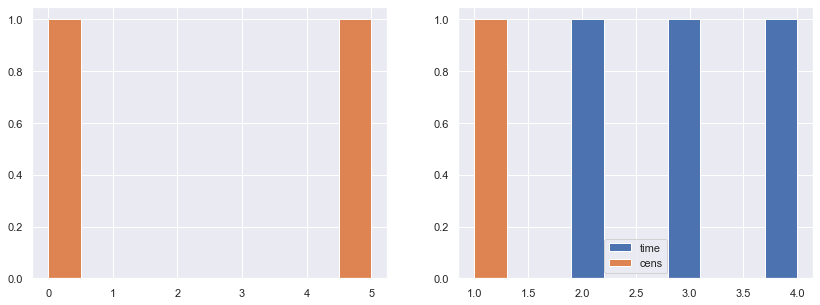

BASE: 0.5697674751281738 0.4503513303609388
BALANCE: 0.5697674751281738 0.4503513303609388
dis_coef: 2


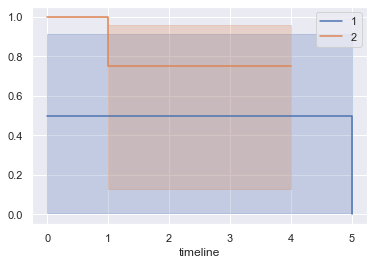

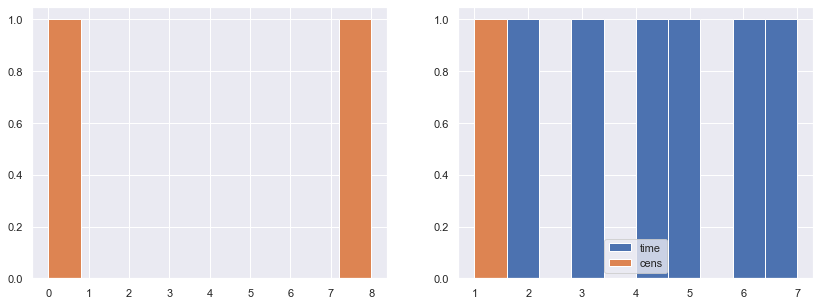

BASE: 1.5099111795425415 0.21915264008581212
BALANCE: 1.2652583122253418 0.2606581056757035
dis_coef: 3


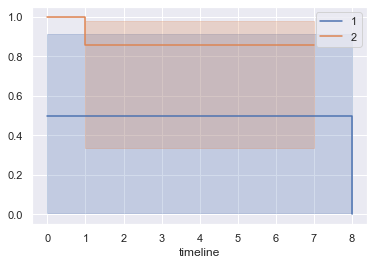

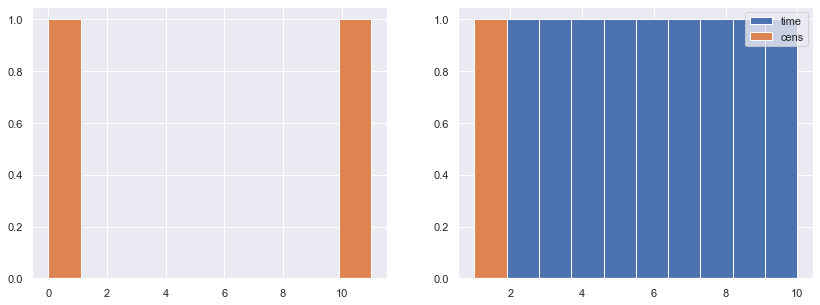

BASE: 2.4880828857421875 0.11471137863217283
BALANCE: 1.9606589078903198 0.16144286698856225


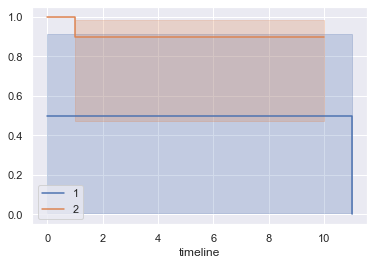

In [435]:
dur1 = np.array([1, 1200])
cens1 = np.array([1, 1])

dur2_0 = np.array([120, 200, 300, 400])
cens2_0 = np.array([1, 0, 0, 0])

dur2_1 = np.array([120, 200, 300, 400, 500, 600, 700])
cens2_1 = np.array([1, 0, 0, 0, 0, 0, 0])

dur2_2 = np.array([120, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
cens2_2 = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

show_stat_difference(dur1, dur2_0, cens1, cens2_0)
show_stat_difference(dur1, dur2_1, cens1, cens2_1)
show_stat_difference(dur1, dur2_2, cens1, cens2_2)

dis_coef: 1


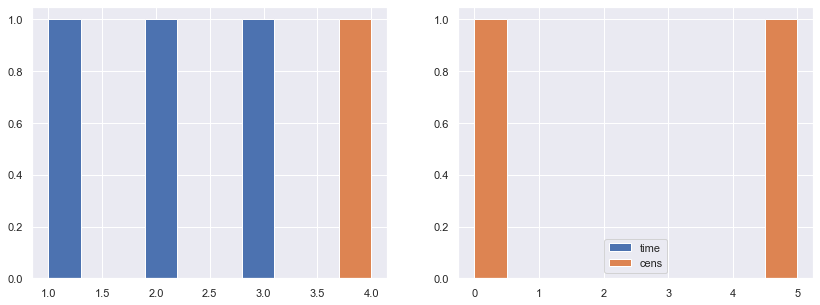

BASE: 0.05882354453206062 0.8083651317642719
BALANCE: 0.05882354453206062 0.8083651317642719
dis_coef: 2


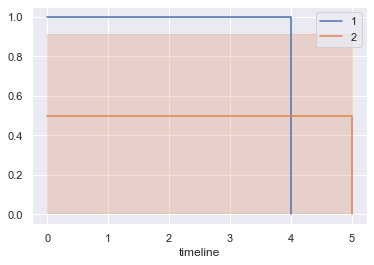

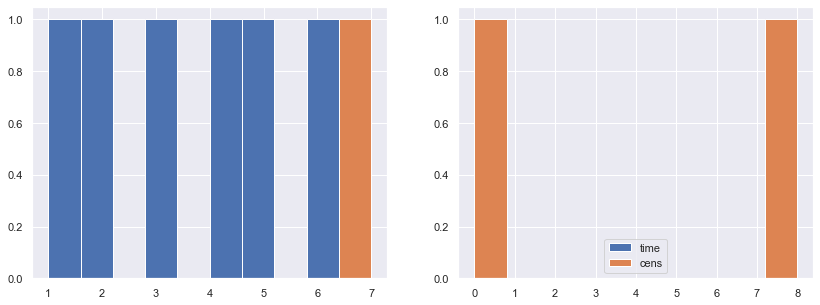

BASE: 0.1824817657470703 0.6692490684914318
BALANCE: 0.15068496763706207 0.6978816362825335
dis_coef: 3


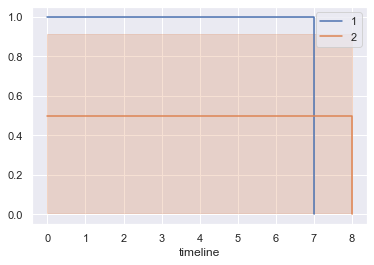

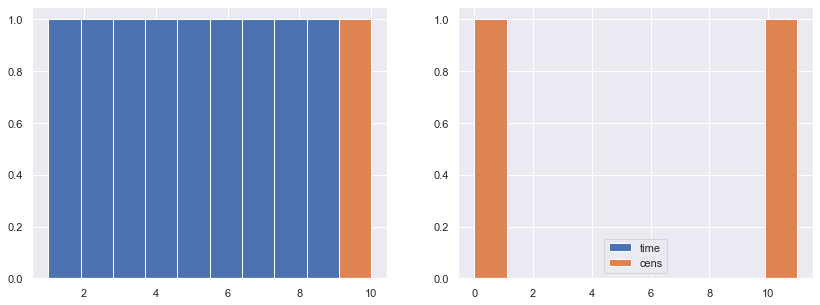

BASE: 0.2857142388820648 0.5929801283177174
BALANCE: 0.24079319834709167 0.6236338112391028


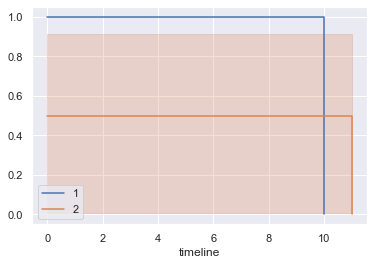

In [439]:
dur1 = np.array([1, 1200])
cens1 = np.array([1, 1])

dur2_0 = np.array([90, 100, 110, 120])
cens2_0 = np.array([0, 0, 0, 1])

dur2_1 = np.array([60, 70, 80, 90, 100, 110, 120])
cens2_1 = np.array([0, 0, 0, 0, 0, 0, 1])

dur2_2 = np.array([30, 40, 50, 60, 70, 80, 90, 100, 110, 120])
cens2_2 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

show_stat_difference(dur2_0, dur1, cens2_0, cens1)
show_stat_difference(dur2_1, dur1, cens2_1, cens1)
show_stat_difference(dur2_2, dur1, cens2_2, cens1)

dis_coef: 1


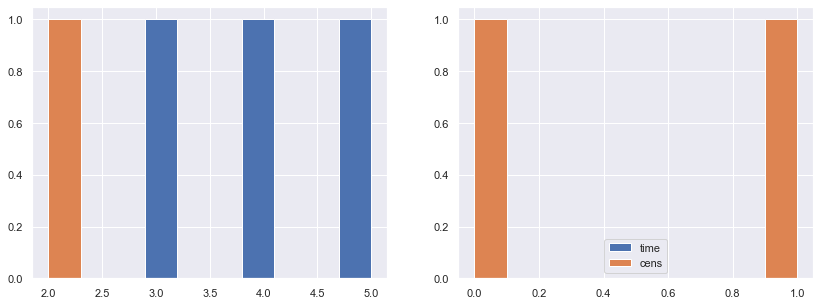

BASE: 5.627906799316406 0.017676727235103523
BALANCE: 5.627906799316406 0.017676727235103523
dis_coef: 2


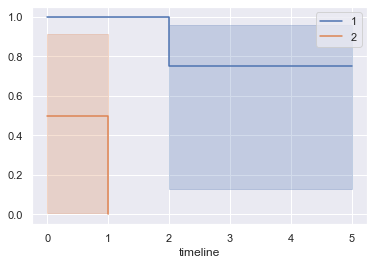

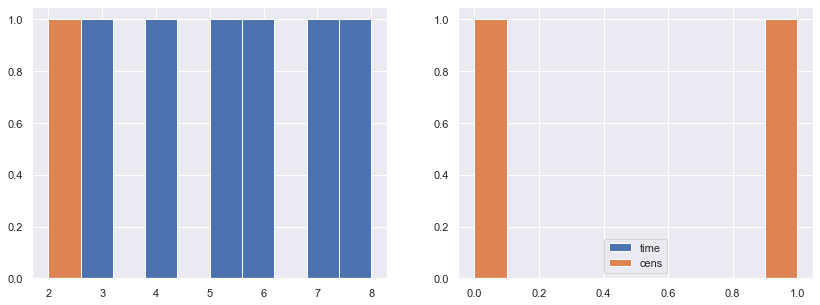

BASE: 9.679425239562988 0.0018634291292103867
BALANCE: 12.497653007507324 0.00040746358322462316
dis_coef: 3


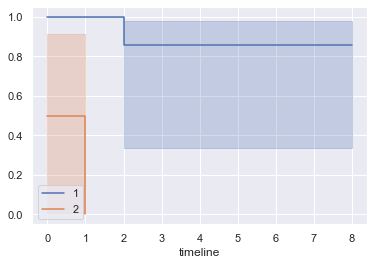

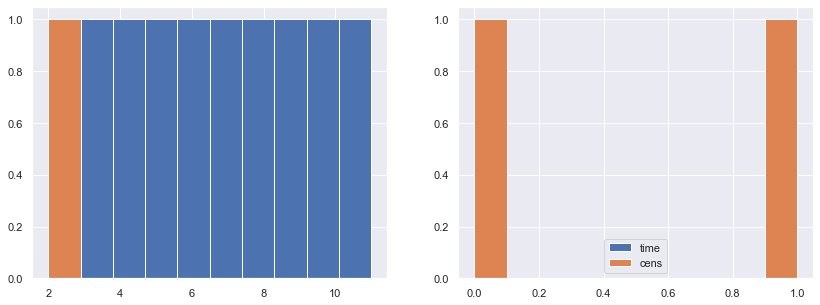

BASE: 13.704662322998047 0.000213922755503931
BALANCE: 19.36651039123535 1.0788245175571269e-05


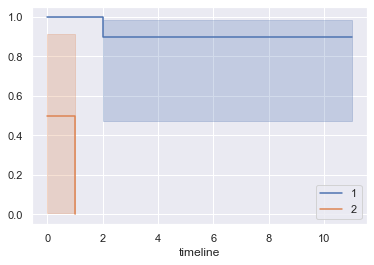

In [440]:
dur1 = np.array([1, 12])
cens1 = np.array([1, 1])

dur2_0 = np.array([30, 40, 50, 60])
cens2_0 = np.array([1, 0, 0, 0])

dur2_1 = np.array([30, 40, 50, 60, 70, 80, 90])
cens2_1 = np.array([1, 0, 0, 0, 0, 0, 0])

dur2_2 = np.array([30, 40, 50, 60, 70, 80, 90, 100, 110, 120])
cens2_2 = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

show_stat_difference(dur2_0, dur1, cens2_0, cens1)
show_stat_difference(dur2_1, dur1, cens2_1, cens1)
show_stat_difference(dur2_2, dur1, cens2_2, cens1)

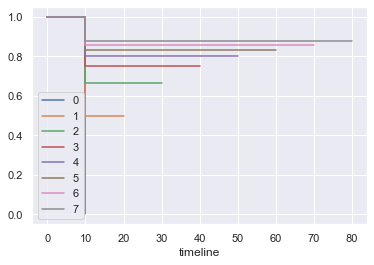

In [469]:
dur = np.array([10])
cens = np.array([1])

for i in range(20, 100, 10):
    kmf = KaplanMeierFitter(label=f"{(cens==0).sum()}")
    kmf.fit(dur, cens)
    kmf.plot(ci_show=False)
    
    dur = np.append(dur, i)
    cens = np.append(cens, 0)

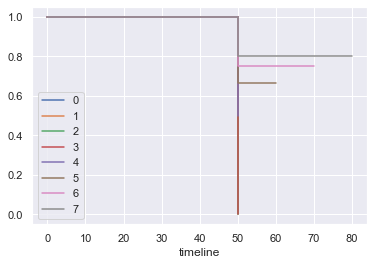

In [472]:
dur = np.array([50])
cens = np.array([1])

for i in range(20, 100, 10):
    kmf = KaplanMeierFitter(label=f"{(cens==0).sum()}")
    kmf.fit(dur, cens)
    kmf.plot(ci_show=False)
    
    dur = np.append(dur, i)
    cens = np.append(cens, 0)

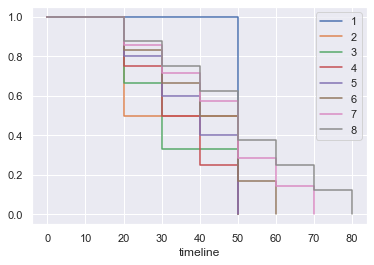

In [473]:
dur = np.array([50])
cens = np.array([1])

for i in range(20, 100, 10):
    kmf = KaplanMeierFitter(label=f"{(cens==1).sum()}")
    kmf.fit(dur, cens)
    kmf.plot(ci_show=False)
    
    dur = np.append(dur, i)
    cens = np.append(cens, 1)